In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.stats as st

In [2]:
# Set random seeds
RANDOM_SEED = 337310097361442377075356538299924202755
random.seed(RANDOM_SEED)
rng = np.random.default_rng(seed=RANDOM_SEED)

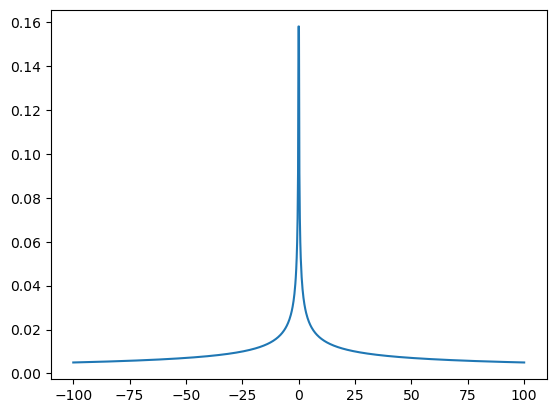

In [3]:
# Agent network
N_agents = 100      # number of agents
N_x = 1000          # number of state grid points
x_min = -100        # Min state value
x_max = -x_min      # Max state value (usually symmetric)
x_grid = np.linspace(x_min, x_max, num=N_x)

# Priors ~ p(x_i) (before observing any z_i)
prior1 = st.uniform(loc=x_min, scale=x_max-x_min)
prior2 = st.norm(0,5)

# Likelhood model ~ p(z|x_i)
likelihood = st.norm(0,5)   # Usage: ask for likelihood.logpdf(x_i-z_i)

# Dists ~ stochastically blurred actual world state
dist1 = st.norm(0, 5)
# Note: Power laws have well defined mean/finite variance for a>2/a>3 only!
dist2 = st.powerlaw(a=0.5, scale=x_max)

plt.plot(x_grid, dist2.pdf(abs(x_grid)))


In [4]:
N_z = 10

# Draw N_z agent-individual observations
z1 = dist1.rvs(size=(N_agents, N_z))
z2 = dist2.rvs(size=(N_agents, N_z))
z2 = np.where(st.uniform.rvs(size=(N_agents, N_z)) < 0.5, z2, -z2) # get negative values for power law via coin flipping

In [5]:
# Define relative beliefs p(x_i|z); x_i in x_grid; for each agent; starting with priors
bel_p1z1 = np.tile(prior1.logpdf(x_grid), (N_agents,1))
bel_p1z2 = bel_p1z1.copy()
bel_p2z1 = np.tile(prior2.logpdf(x_grid), (N_agents,1))
bel_p2z2 = bel_p2z1.copy()

# Recursive Bayesian update (without state dynamics, i.e. dist1, dist2 = const.)
for a in range(N_agents):
    for z in range(N_z):
        bel_p1z1[a,:] += likelihood.logpdf(x_grid-z1[a,z])
        bel_p1z2[a,:] += likelihood.logpdf(x_grid-z2[a,z])
        bel_p2z1[a,:] += likelihood.logpdf(x_grid-z1[a,z])
        bel_p2z2[a,:] += likelihood.logpdf(x_grid-z2[a,z])


Text(0.5, 1.0, 'Power law data')

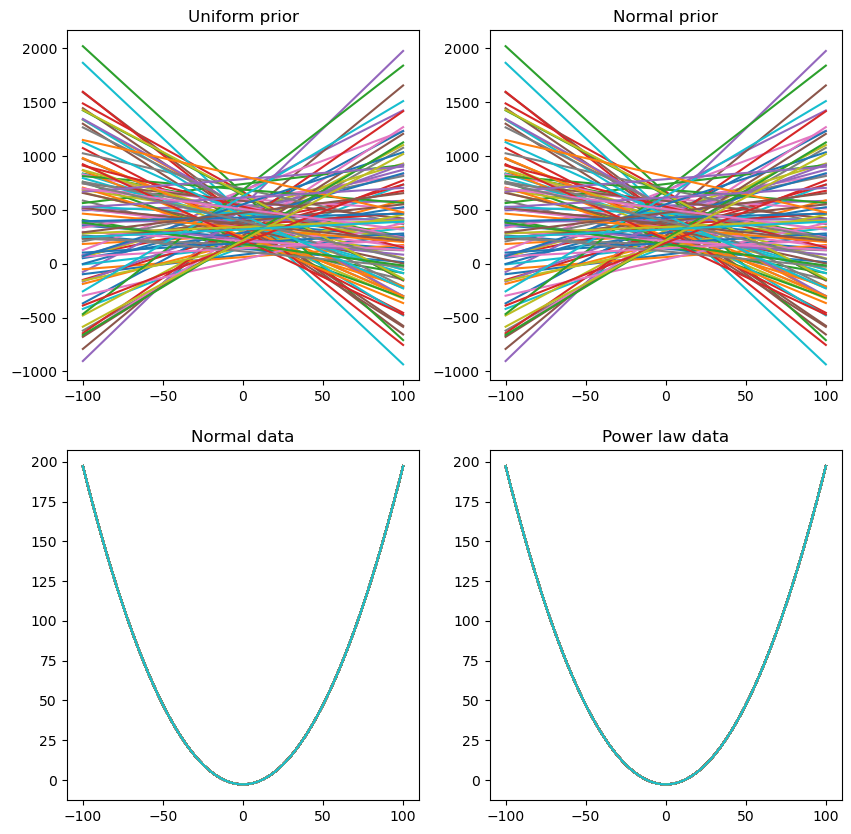

In [6]:
# Comparison of results: Plot differences of same agent in different scenarios
my_plot = lambda axs, M, a, b: axs.plot(x_grid, a[M,:]-b[M,:])

fig, axs = plt.subplots(2, 2, figsize=(10,10))
for i in range(N_agents):
    my_plot(axs[0,0], i, bel_p1z1, bel_p1z2)
    my_plot(axs[0,1], i, bel_p2z1, bel_p2z2)
    my_plot(axs[1,0], i, bel_p1z1, bel_p2z1)
    my_plot(axs[1,1], i, bel_p1z2, bel_p2z2)

axs[0,0].set_title('Uniform prior')
axs[0,1].set_title('Normal prior')
axs[1,0].set_title('Normal data')
axs[1,1].set_title('Power law data')


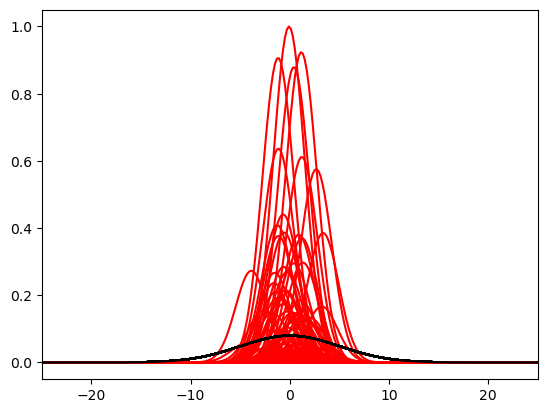

In [7]:
my_plot = lambda axs, M, a, b: axs.plot(x_grid, a[M,:]-b[M,:])

def offset_bel(bel):
    bel = bel - np.max(bel)
    return np.exp(bel)

foo = offset_bel(bel_p1z1)
for i in range(N_agents):
    plt.plot(x_grid, foo[i], label='true', color='red')
    plt.plot(x_grid, dist1.pdf(abs(x_grid)), label='true', color='black')
    plt.xlim([-25,25])
    #plt.ylim([-1500,100])
